In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
from rflearn.env import BlackJack, GridWorld
from rflearn.algo import MCIteration

# Gridworld MC

In [28]:
# _grid = [
#     [0, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0],
# ]
# grid = GridWorld(grid=_grid, terminals=[0])
grid = GridWorld(4, 4)
value = np.zeros(shape=len(grid.S))
policy = np.ones(shape=(len(grid.S), len(grid.A))) / len(grid.A)

mc_model = MCIteration(grid, value, policy, qvalue=None)
mc_model.fit(gamma=1, epsilon=0.05)

In [29]:
mc_model.transform(iter=50000)

100%|██████████| 50000/50000 [00:09<00:00, 5493.62it/s]


In [30]:
q_vals = pd.Series(mc_model.qvalue).unstack()[grid.A]
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
v_vals = (q_vals * pi_vals).sum(1)
np.round(v_vals.values.reshape(grid.shape))

array([[  0.,  -3.,  -5.,  -6.],
       [ -1.,  -4.,  -3.,  -3.],
       [ -5.,  -5.,  -2.,  -1.],
       [-25.,  -3.,  -1.,   0.]])

In [19]:
pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]

,up,down,left,right
0,0,0,0,0
1,122,113,10115,151
2,144,10430,122,139
3,69,78,5245,77
4,5048,141,57,59
5,5067,75,64,384
6,186,15685,208,211
7,80,5407,72,71
8,135,5336,163,157
9,68,5664,159,71


# Blackjack MC

In [21]:
game = BlackJack(debug=False)
value = np.zeros(shape=len(game.S))
policy = []
for idx in game.S:
    state = game._to_state(idx)
    if state[1] >= 20:
        policy.append([0, 1])
    else:
        policy.append([1, 0])
policy = np.array(policy).astype('float')

mc_model = MCIteration(game, value, policy)
mc_model.fit(gamma=1, epsilon=0.0)

In [22]:
mc_model.transform(50000)

100%|██████████| 50000/50000 [00:06<00:00, 8136.18it/s]


In [23]:
idx = pd.MultiIndex.from_tuples([game._to_state(s) for s in game.S])
q_vals = pd.Series(mc_model.qvalue).unstack()[game.A]
q_vals.index = idx
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
pi_vals.index = idx
v_vals = (q_vals * pi_vals).sum(1)

cnts = pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]
cnts.index = idx

<AxesSubplot:>

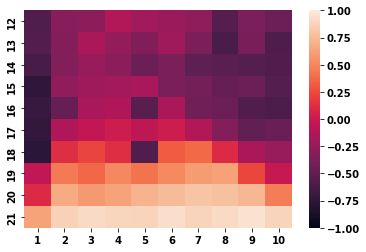

In [27]:
import seaborn as sns

sns.heatmap(np.round(v_vals.unstack(), 2).T[False].T, vmin=-1, vmax=1)